<a href="https://colab.research.google.com/github/Jaimemorillo/ShouldIwatchThisMovie/blob/master/Memoria_experiment2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Aplicamos las técnicas de preprocesamiento y las entrenamos con una red densa

In [47]:
!python -m spacy download es_core_news_sm

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')


In [48]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [49]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
tqdm.pandas()

from numpy.random import seed
seed(9)

import tensorflow as tf
tf.random.set_seed(9)

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

import nltk
from nltk.tokenize import WordPunctTokenizer
import keras
import re
import string
from collections import Counter

nltk.download("popular")
nltk.download('stopwords')
print(tf.__version__)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

In [50]:
df = pd.read_csv("gdrive/My Drive/TFG/overviews_final.csv", sep='#',encoding='utf-8', lineterminator='\n')

df['text_array'] = df.overview.str.split(" ")
df['n_words'] = df['text_array'].apply(lambda x: len(x))
df = df.drop(columns=['text_array'])
#df = df[df['n_words']>15]

df.shape

(1015, 9)

In [51]:
df['new_overviews'] = df['new_overviews'].progress_apply(lambda x: eval(x))

In [52]:
# Count
ini_n_words = len(Counter(" ".join(df.overview).split()))

In [53]:
# Normalización

def normalize(x):
  x = x.lower()
  replacements = (
      ("á", "a"),
      ("é", "e"),
      ("í", "i"),
      ("ó", "o"),
      ("ú", "u"),
      ("ñ", "n")
  )
  for a, b in replacements:
      x = x.replace(a, b)

  x = x.translate(str.maketrans('','',string.punctuation))
  x = x.translate(str.maketrans('','','ªº¡¿'))   
  x = x.replace("  ", " ") 
  return x

In [54]:
df['overview'] = df['overview'].progress_apply(lambda x: normalize(x))
df['new_overviews'] = df['new_overviews'].progress_apply(lambda x: [normalize(i) for i in x])

In [55]:
# Count
normalize_n_words = len(Counter(" ".join(df.overview).split()))

In [56]:
# Stop_words

stop_words = pd.read_csv("gdrive/My Drive/TFG/stopwords-es.txt",header=None)
stop_words = stop_words[0].tolist()
stop_words = [normalize(word) for word in stop_words]

def delete_stop_words(x):
  words = x.split(' ')
  words = [word for word in words if word not in stop_words]
  x = str(' '.join(words))
  return x

In [57]:
df['overview'] = df['overview'].progress_apply(lambda x: delete_stop_words(x))
df['new_overviews'] = df['new_overviews'].progress_apply(lambda x: [delete_stop_words(i) for i in x])

In [58]:
# Count
sw_n_words = len(Counter(" ".join(df.overview).split()))

In [59]:
# Lemmatization

import spacy

nlp = spacy.load('es_core_news_sm')

def lemmatize_sentece(sentence):  
  doc = nlp(sentence)
  return ' '.join([word.lemma_ for word in doc])

In [60]:
df_lemma = df.copy()
df_lemma['overview'] = df['overview'].progress_apply(lambda x: lemmatize_sentece(x))
df_lemma['new_overviews'] = df['new_overviews'].progress_apply(lambda x: [lemmatize_sentece(i) for i in x])

In [61]:
# Count
lemma_n_words = len(Counter(" ".join(df_lemma.overview).split()))

In [62]:
# Steaming

from nltk import word_tokenize
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer("spanish", ignore_stopwords=True)

def stem_sentence(sentence):
  stemmed_text = [stemmer.stem(word) for word in word_tokenize(sentence)]
  return " ".join(stemmed_text)

In [63]:
df['overview'] = df['overview'].progress_apply(lambda x: stem_sentence(x))
df['new_overviews'] = df['new_overviews'].progress_apply(lambda x: [stem_sentence(i) for i in x])

In [64]:
df_lemma['overview'] = df_lemma['overview'].progress_apply(lambda x: stem_sentence(x))
df_lemma['new_overviews'] = df_lemma['new_overviews'].progress_apply(lambda x: [stem_sentence(i) for i in x])

In [65]:
# Count
stemming_n_words = len(Counter(" ".join(df.overview).split()))
stemming_lemma_n_words = len(Counter(" ".join(df_lemma.overview).split()))

In [66]:
step = ['Inicio', 'Norm.', 'Stop Words', 'Lemmatization', 'Steamming', 'Lemma. + Steam.']
n_words = [ini_n_words, normalize_n_words, sw_n_words, lemma_n_words, stemming_n_words, stemming_lemma_n_words]

data_count = {
    'Preprocesamiento': step,
    'N palabras': n_words
}

df_count = pd.DataFrame(data=data_count)

In [67]:
df_count

,Preprocesamiento,N palabras
0,Inicio,16994
1,Norm.,12487
2,Stop Words,12053
3,Lemmatization,9113
4,Steamming,7939
5,Lemma. + Steam.,7692


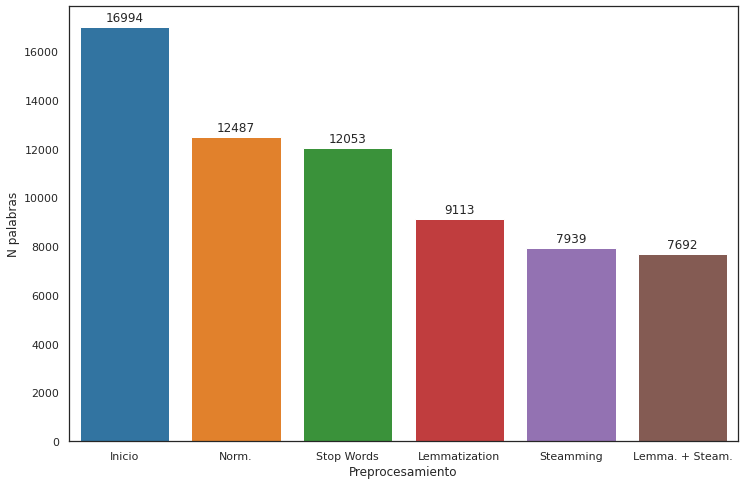

In [68]:
# https://datavizpyr.com/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/

fig, ax = plt.subplots(figsize=(12, 8))
splot = sns.barplot(x="Preprocesamiento", y="N palabras", data=df_count, ax=ax)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

Eligimos combinación (Norm. + SW + Stemming) es la manera más equilibrada en cuanto a rendimiento y cantidad de vocabulario que reducimos. Descartamos por tanto aplicar Lemma.

Nos queamos con un vocabulario de 8491

## Sin text augmentation

In [147]:
X = df.drop(columns=['like'])
y = df['like'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1996)

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10/90, stratify=y_train, random_state=1996) 

X_train = X_train['overview']
X_test = X_test['overview']
#X_val = X_val['overview']

In [148]:
X_test.head(5)

322    ano acos ben willis victim mortal accident imp...
939    human genet modific envi recuper carg vital su...
695    emil mied mund sal call pint azul noch hij yoa...
831    dispuest oats studi present capitul adam tribu...
598    pelicul ambient galardon seri estren safornica...
Name: overview, dtype: object

In [ ]:
len(X_train)

812

In [ ]:
vectorizer = CountVectorizer(stop_words=stop_words)
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)
#X_val = vectorizer.transform(X_val)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

input_dim = X_train.shape[1]  # Number of features

# Test with Sequential Model 

model = Sequential()
model.add(layers.Dense(25, input_dim=input_dim, 
                       activation='relu',
                       name='dense_1'))
model.add(layers.Dense(1, activation='sigmoid', name='dense_2'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                174650    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 174,676
Trainable params: 174,676
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 8
batch_size = 4

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=batch_size)

Epoch 1/8
203/203 [==============================] - 1s 4ms/step - loss: 0.6894 - accuracy: 0.5409 - val_loss: 0.6743 - val_accuracy: 0.6650
Epoch 2/8
203/203 [==============================] - 1s 3ms/step - loss: 0.6386 - accuracy: 0.8193 - val_loss: 0.6444 - val_accuracy: 0.7389
Epoch 3/8
203/203 [==============================] - 1s 3ms/step - loss: 0.5767 - accuracy: 0.9392 - val_loss: 0.6057 - val_accuracy: 0.8128
Epoch 4/8
203/203 [==============================] - 1s 3ms/step - loss: 0.4908 - accuracy: 0.9709 - val_loss: 0.5642 - val_accuracy: 0.8177
Epoch 5/8
203/203 [==============================] - 1s 3ms/step - loss: 0.4260 - accuracy: 0.9799 - val_loss: 0.5250 - val_accuracy: 0.8522
Epoch 6/8
203/203 [==============================] - 1s 3ms/step - loss: 0.3435 - accuracy: 0.9891 - val_loss: 0.4922 - val_accuracy: 0.8522
Epoch 7/8
203/203 [==============================] - 1s 3ms/step - loss: 0.2892 - accuracy: 0.9876 - val_loss: 0.4659 - val_accuracy: 0.8571
Epoch 8/8
203

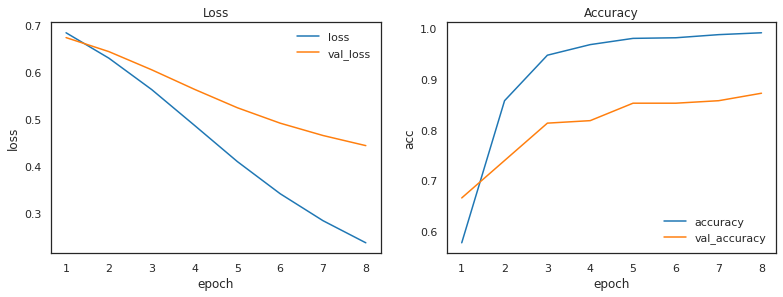

In [ ]:
#Plot history

fit_history = pd.DataFrame(history.history)
fit_history['epoch'] = fit_history.index + 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.25))
fit_history.plot(x='epoch', y=['loss', 'val_loss'], kind='line', ylabel='loss', title='Loss', ax=ax1)
fit_history.plot(x='epoch', y=['accuracy', 'val_accuracy'], kind='line', ylabel='acc', title='Accuracy', ax=ax2)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score

y_pred = (model.predict(X_test) > 0.5).astype("int32")
y_true = y_test

print('Acc: ' + str(accuracy_score(y_true, y_pred).round(4)))
print('Precision: ' + str(precision_score(y_true, y_pred).round(4)))
print('Recall: ' + str(recall_score(y_true, y_pred).round(4)))
print('F1: ' + str(f1_score(y_true, y_pred).round(4)))
print('Conf. Matrix: ')
print(confusion_matrix(y_true, y_pred))

Acc: 0.8719
Precision: 0.8854
Recall: 0.85
F1: 0.8673
Conf. Matrix: 
[[92 11]
 [15 85]]


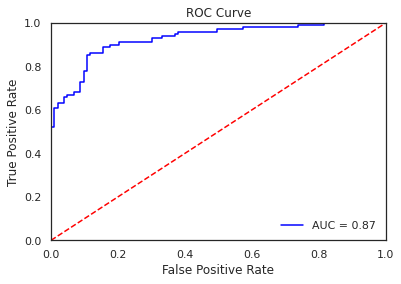

AUC: 0.8716


In [ ]:
y_pred_keras = model.predict(X_test).flatten()
fpr, tpr, thresholds = roc_curve(y_true, y_pred_keras)
roc_auc = roc_auc_score(y_true, y_pred)

def plot_roc_curve(fpr,tpr): 
  plt.title('ROC Curve')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()   
  
plot_roc_curve(fpr,tpr) 
print('AUC: ' + str(roc_auc.round(4)))

## Con text augmentation

In [149]:
X = df.drop(columns=['like'])
y = df['like']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1996)

X_test = X_test['overview']
y_test = y_test.values

In [150]:
X_test.head(5)

322    ano acos ben willis victim mortal accident imp...
939    human genet modific envi recuper carg vital su...
695    emil mied mund sal call pint azul noch hij yoa...
831    dispuest oats studi present capitul adam tribu...
598    pelicul ambient galardon seri estren safornica...
Name: overview, dtype: object

In [151]:
X_train_new = X_train['overview'].copy()
y_train_new = y_train.copy()

for i in range(0, len(X_train)):
  new_series_X = pd.Series(X_train.iloc[i]['new_overviews'])
  X_train_new = X_train_new.append(new_series_X, ignore_index=True)

  y_value = y_train.iloc[i]
  new_series_y = pd.Series([y_value, y_value])
  y_train_new = y_train_new.append(new_series_y, ignore_index=True)

y_train_new = y_train_new.values

In [152]:
# Count
corpus_augment = ""
for i in range(0, len(df)):
  corpus_augment = corpus_augment + " ".join(df.iloc[i]['new_overviews'])

full_corpus = " ".join(df['overview']) + "" + corpus_augment
augm_n_words = len(Counter(full_corpus.split()))
augm_n_words

10787

In [153]:
vectorizer = CountVectorizer(stop_words=stop_words)
vectorizer.fit(X_train_new)
X_train_new = vectorizer.transform(X_train_new)
X_test  = vectorizer.transform(X_test)

In [161]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

input_dim = X_train_new.shape[1]  # Number of features

# Test with Sequential Model 

model = Sequential()
model.add(layers.Dense(25, input_dim=input_dim, 
                       activation='relu',
                       name='dense_1'))
model.add(layers.Dense(1, activation='sigmoid', name='dense_2'))

In [162]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                218150    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 218,176
Trainable params: 218,176
Non-trainable params: 0
_________________________________________________________________


In [163]:
epochs = 4
batch_size = 4

history = model.fit(X_train_new, y_train_new,
                    epochs=epochs,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=batch_size)

Epoch 1/4
609/609 [==============================] - 2s 2ms/step - loss: 0.6754 - accuracy: 0.6187 - val_loss: 0.6216 - val_accuracy: 0.7882
Epoch 2/4
609/609 [==============================] - 1s 2ms/step - loss: 0.5017 - accuracy: 0.9632 - val_loss: 0.5166 - val_accuracy: 0.8374
Epoch 3/4
609/609 [==============================] - 1s 2ms/step - loss: 0.3061 - accuracy: 0.9869 - val_loss: 0.4511 - val_accuracy: 0.8374
Epoch 4/4
609/609 [==============================] - 1s 2ms/step - loss: 0.1895 - accuracy: 0.9950 - val_loss: 0.4137 - val_accuracy: 0.8424


https://stats.stackexchange.com/questions/258166/good-accuracy-despite-high-loss-value

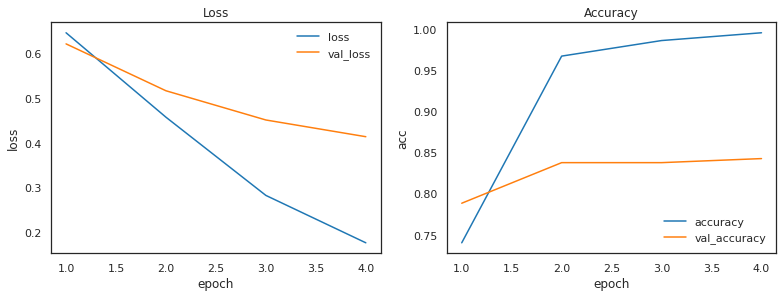

In [164]:
#Plot history

fit_history = pd.DataFrame(history.history)
fit_history['epoch'] = fit_history.index + 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.25))
fit_history.plot(x='epoch', y=['loss', 'val_loss'], kind='line', ylabel='loss', title='Loss', ax=ax1)
fit_history.plot(x='epoch', y=['accuracy', 'val_accuracy'], kind='line', ylabel='acc', title='Accuracy', ax=ax2)

In [165]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score

y_pred = (model.predict(X_test) > 0.5).astype("int32")
y_true = y_test

print('Acc: ' + str(accuracy_score(y_true, y_pred).round(4)))
print('Precision: ' + str(precision_score(y_true, y_pred).round(4)))
print('Recall: ' + str(recall_score(y_true, y_pred).round(4)))
print('F1: ' + str(f1_score(y_true, y_pred).round(4)))
print('Conf. Matrix: ')
print(confusion_matrix(y_true, y_pred))

Acc: 0.8424
Precision: 0.8469
Recall: 0.83
F1: 0.8384
Conf. Matrix: 
[[88 15]
 [17 83]]


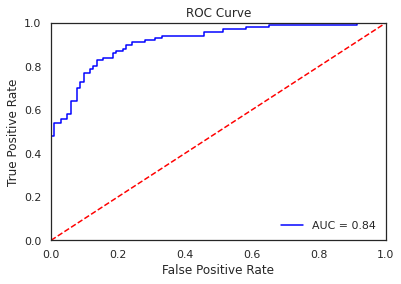

AUC: 0.8422


In [166]:
y_pred_keras = model.predict(X_test).flatten()
fpr, tpr, thresholds = roc_curve(y_true, y_pred_keras)
roc_auc = roc_auc_score(y_true, y_pred)

def plot_roc_curve(fpr,tpr): 
  plt.title('ROC Curve')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()   
  
plot_roc_curve(fpr,tpr) 
print('AUC: ' + str(roc_auc.round(4)))

In [167]:
step = ['Inicio', 'Norm. + S.W. + Steam.', 'Text Aug.']
n_words = [ini_n_words, stemming_n_words, augm_n_words]

data_count = {
    'Preprocesamiento': step,
    'N palabras': n_words
}

df_count = pd.DataFrame(data=data_count)

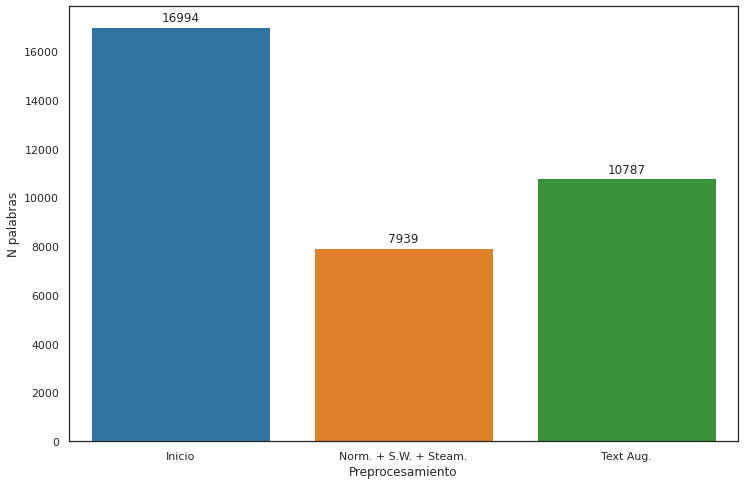

In [168]:
fig, ax = plt.subplots(figsize=(12, 8))
splot = sns.barplot(x="Preprocesamiento", y="N palabras", data=df_count, ax=ax)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')